# In this classwork we will a) show how to load image data with Pytorch. Then we will b) build and train a feed forward and a convolutional neural network to classify images as Cat Vs No-Cat, c) learn how to use a validation set to evaluate the performance during training d) use regularization techniques to suppress overfitting e) save a trained model to infer on a testin dataset

Make the necessary imports

In [1]:
import os
import glob
from pathlib import Path
import IPython.display
from PIL import Image
import h5py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

Inspect the folder that the data are located

You can download the dataset from here : https://www.kaggle.com/c/dogs-vs-cats/data

In [233]:
# set the path that the images are created
cats_path = 'PetImages/Cat/'
dogs_path = 'PetImages/Dog/'
for i, abspath in enumerate(glob.glob(cats_path + '*')):
    path, filename = os.path.split(abspath)
    print(filename)
    if i==5: break 

2374.jpg
8500.jpg
9295.jpg
4316.jpg
5958.jpg
6961.jpg


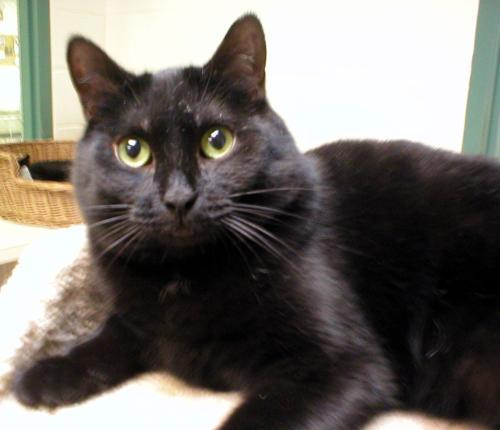

In [235]:
# load a test image and show it
test_cat = cats_path +'174.jpg'
test_dog = dogs_path +'234.jpg'

IPython.display.Image(filename =test_cat , width = 300, height = 300)
IPython.display.Image(filename =test_dog , width = 300, height = 300)

In [236]:
# inspect the atributes of the image
image = Image.open(test_cat)
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)


JPEG
RGB
(500, 430)


uint8
(430, 500, 3)


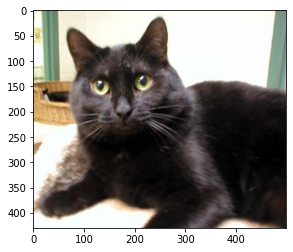

In [237]:
# Now load the test image in a vectorized way
data = matplotlib.image.imread(test_cat)
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
plt.imshow(data)
plt.show()

The three different dimensions correspond to (x pixels, y pixels, colours)

Now let's read 100 cat images and 100 dog images save them as a numpy. Sometimes we need to pad the input data because the number of pixels in every image differs. For that we will use the padding function below.

In [238]:
def pad(img, h, w):
    top_pad = np.floor((h - img.shape[0]) / 2).astype(np.uint16)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(np.uint16)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(np.uint16)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(np.uint16)
    
    return np.copy(np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant', constant_values=0))

# First the cats
cat_list = []
dog_list = []

i=0
for cat_abs_path, dog_abs_path in zip(glob.glob(cats_path + '*'), glob.glob(dogs_path + '*')):
    
    i+=1
    cat_name = os.path.split(cat_abs_path)[1]
    dog_name = os.path.split(dog_abs_path)[1]
    
    data_cat = matplotlib.image.imread(cats_path + cat_name)
    data_dog = matplotlib.image.imread(dogs_path + cat_name)
    
    if data_cat.shape[2] != 3 or data_dog.shape[2]!=3 : continue
    
    cat_list.append(pad(data_cat, 600, 600))   
    dog_list.append(pad(data_dog, 600, 600))
    
    if i > 100: break
        
print('Shapes in the list', dog_list[0].shape, cat_list[0].shape)

#make sure that all the images have the same dimensions,
for i, j in zip(cat_list, dog_list): 
    if i.shape != cat_list[0].shape or j.shape != dog_list[0].shape:
        print(i.shape, j.shape)
        raise ValueError ('Something is wrong')

Shapes in the list (600, 600, 3) (600, 600, 3)


Now create two numpy arrays of the images

In [239]:
dog_images = np.stack(dog_list, axis=0 )
cat_images = np.stack(cat_list, axis=0 )
print(dog_images.shape, cat_images.shape)

(99, 600, 600, 3) (99, 600, 600, 3)


Print the images and see the padding effect

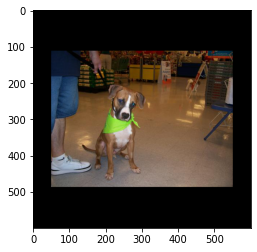

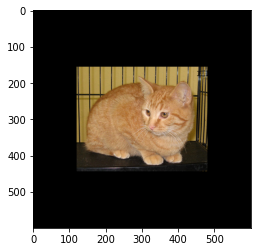

In [240]:
plt.imshow(dog_images[4])
plt.show()
plt.imshow(cat_images[4])
plt.show()

Now create the labels

In [248]:
dog_labels = np.zeros(dog_images.shape[0])
cat_labels = np.ones(cat_images.shape[0])


mix cats and dogs

In [249]:
images = np.concatenate([dog_images, cat_images], axis=0)
labels = np.concatenate([dog_labels, cat_labels], axis=0)

shuffler = np.random.permutation(len(images))
images_shuff= images[shuffler]
labels_shuff = labels[shuffler]

In [247]:
np.save('images.npy', images_shuff)
np.save('labels.npy', labels_shuff)

# Now let's see how this becomes way easier with the Pytorch functions

https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

you can check here how all the transforms look like

In [251]:
npixels = 64
#crop = npixels-2

transformation = torchvision.transforms.Compose(
    [transforms.Resize([npixels, npixels]),
    #transforms.RandomCrop(crop),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)

root_path = 'PetImages/'

batch_size = 8

data_train = datasets.ImageFolder(root=root_path,
                            transform=transformation,
                            )

train_X = torch.utils.data.Subset(data_train,
                                  np.random.choice(
                                      len(data_train),
                                      2000,
                                      replace=False
                                  )
                                 )

train_loader = torch.utils.data.DataLoader(data_train,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            drop_last=True
                                          )

let's see what we actually did

Iterating the dataloader
Gives us a list of length 3125
Which is the number of batches of data
By taking one batch, we get a list of: 2
with two tensors: 0th torch.Size([8, 3, 64, 64]) 1st torch.Size([8])
Pytorch created the labels for us. Let us verify:


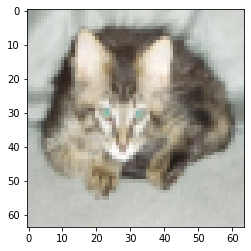

With label: tensor(0)


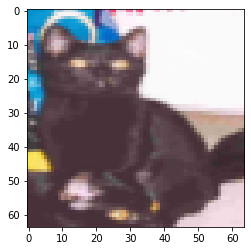

With label: tensor(0)


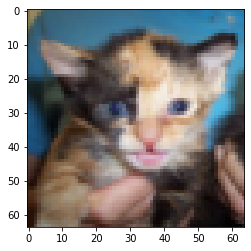

With label: tensor(0)


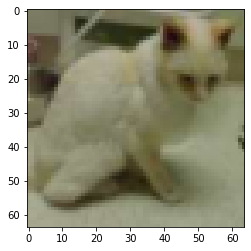

With label: tensor(0)


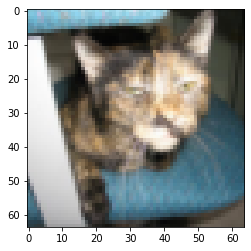

With label: tensor(0)


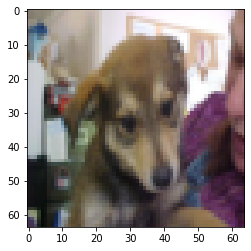

With label: tensor(1)


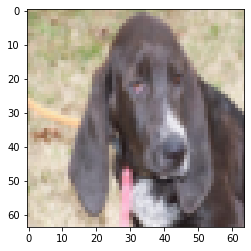

With label: tensor(1)


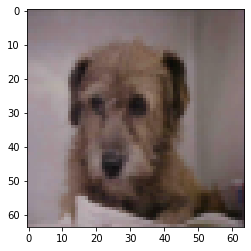

With label: tensor(1)


In [252]:
print('Iterating the dataloader')
e = iter(train_loader)
print('Gives us a list of length', len(e))
print('Which is the number of batches of data')
e.next()
samples = e.next()
print('By taking one batch, we get a list of:', len(samples))
print('with two tensors: 0th', samples[0].shape, '1st', samples[1].shape)
print('Pytorch created the labels for us. Let us verify:')
cats = samples[1][:] == 0
idx_cats = np.where(cats==True)
idx_dogs = np.where(cats==False)
for c in idx_cats[0]:
    plt.imshow(samples[0][c].permute(1, 2, 0))
    plt.show()
    print('With label:', samples[1][c])
for d in idx_dogs[0]:
    plt.imshow(samples[0][d].permute(1, 2, 0))
    plt.show()
    print('With label:', samples[1][d])